# Neural Style Transfer

In [44]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K

from imageio import mimsave
from IPython.display import display as display_fn
from IPython.display import Image, clear_output
from pathlib import Path

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


***Utilities***

utility functions below to help in loading, visualizing, and preprocessing the images.

In [12]:
def tensor_to_image(tensor):
  '''converts a tensor to an image'''
  tensor_shape = tf.shape(tensor)
  number_elem_shape = tf.shape(tensor_shape)
  if number_elem_shape > 3:
    assert tensor_shape[0] == 1
    tensor = tensor[0]
  return tf.keras.preprocessing.image.array_to_img(tensor) 


def load_img(path_to_img):
  '''loads an image as a tensor and scales it to 512 pixels'''
  max_dim = 512
  image = tf.io.read_file(path_to_img)
  image = tf.image.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)

  shape = tf.shape(image)[:-1]
  shape = tf.cast(tf.shape(image)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  image = tf.image.resize(image, new_shape)
  image = image[tf.newaxis, :]
  image = tf.image.convert_image_dtype(image, tf.uint8)

  return image


def load_images(content_path, style_path):
  '''loads the content and path images as tensors'''
  content_image = load_img("{}".format(content_path))
  style_image = load_img("{}".format(style_path))

  return content_image, style_image


def imshow(image, title=None):
  '''displays an image with a corresponding title'''
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)
    
    
def show_images_with_objects(images, titles=[]):
  '''displays a row of images with corresponding titles'''
  if len(images) != len(titles):
    return

  plt.figure(figsize=(20, 12))
  for idx, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1, len(images), idx + 1)
    plt.xticks([])
    plt.yticks([])
    imshow(image, title)


def display_gif(gif_path):
  '''displays the generated images as an animated gif'''
  with open(gif_path,'rb') as f:
    display_fn(Image(data=f.read(), format='png'))


def create_gif(gif_path, images):
  '''creates animation of generated images'''
  mimsave(gif_path, images, fps=1)
  
  return gif_path


def clip_image_values(image, min_value=0.0, max_value=255.0):
  '''clips the image pixel values by the given min and max'''
  return tf.clip_by_value(image, clip_value_min=min_value, clip_value_max=max_value)


def preprocess_image(image):
  '''centers the pixel values of a given image to use with VGG-19'''
  image = tf.cast(image, dtype=tf.float32)
  image = tf.keras.applications.vgg19.preprocess_input(image)

  return image

In [123]:
content_path = Path('/content/drive/MyDrive/NST/data/content-images/winter-wolf.jpg')
style_path = Path('/content/drive/MyDrive/NST/data/style-images/bamboo_forest.jpg')

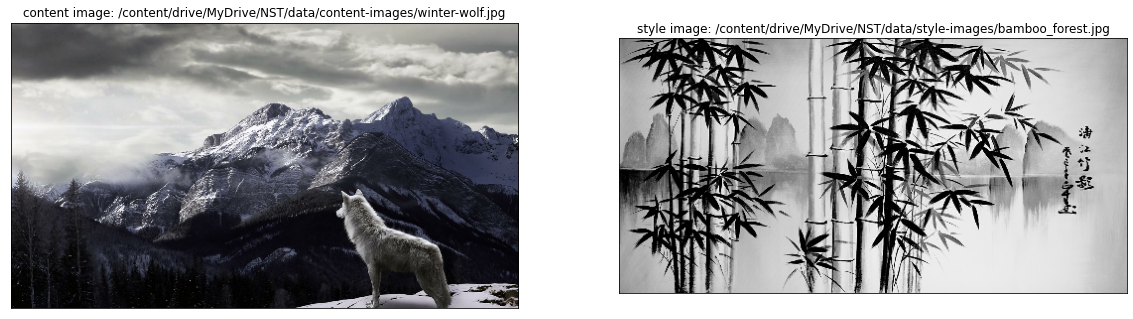

In [124]:
# display the content and style image
content_image, style_image = load_images(content_path, style_path)
show_images_with_objects([content_image, style_image], 
                         titles=[f'content image: {content_path}',
                                 f'style image: {style_path}'])

## Normal Task

### models

Choose 1 of the models

#### VGG-19 as feature extractor


In [118]:
# clear session to make layer naming consistent when re-running this cell
K.clear_session()

# download the vgg19 model and inspect the layers
tmp_vgg = tf.keras.applications.vgg19.VGG19()
tmp_vgg.summary()

# delete temporary variable
del tmp_vgg

574726144/574710816 [==============================] - 7s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

Choose intermediate layers from the network to extract the style and content of the image

In [119]:
# style layers of interest
style_layers = ['block1_conv1', 
                'block1_conv2',
                'block2_conv1', 
                'block2_conv2',
                'block3_conv1', 
                'block3_conv2',
                'block3_conv3',
                'block3_conv4',
                'block4_conv1', 
                'block4_conv2',
                'block4_conv3',
                'block4_conv4',
                'block5_conv1',
                'block5_conv2',
                'block5_conv3',
                'block5_conv4'] 

# or use this
'''
style_layers = ['block1_conv1', 
                'block2_conv1', 
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'] 
'''

# choose the content layer and put in a list
content_layers = ['block5_conv2'] 

# combine the two lists (put the style layers before the content layers)
output_layers = style_layers + content_layers 

# declare auxiliary variables holding the number of style and content layers
NUM_CONTENT_LAYERS = len(content_layers)
NUM_STYLE_LAYERS = len(style_layers)

##### Define the model

In [120]:
def vgg_model(layer_names):
  """ Creates a vgg model that outputs the style and content layer activations.
  
  Args:
    layer_names: a list of strings, representing the names of the desired content and style layers
    
  Returns:
    A model that takes the regular vgg19 input and outputs just the content and style layers.
  
  """

  # load the the pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')

  # freeze the weights of the model's layers (make them not trainable)
  vgg.trainable = False
  
  # create a list of layer objects that are specified by layer_names
  outputs = [vgg.get_layer(name).output for name in layer_names]

  # create the model that outputs content and style layers only
  model = tf.keras.Model(inputs=vgg.input, outputs=outputs)

  return model

In [121]:
# clear session to make layer naming consistent if re-running the cell
K.clear_session()

# create a vgg-19 model
model = vgg_model(output_layers)
model.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

#### VGG-16 as feature extractor

In [86]:
# clear session to make layer naming consistent when re-running this cell
K.clear_session()

# download the vgg16 model and inspect the layers
tmp_vgg = tf.keras.applications.vgg16.VGG16()
tmp_vgg.summary()

# delete temporary variable
del tmp_vgg

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [87]:
# style layers of interest
style_layers = ['block1_conv1', 
                'block1_conv2',
                'block2_conv1', 
                'block2_conv2',
                'block3_conv1', 
                'block3_conv2',
                'block3_conv3',
                'block4_conv1', 
                'block4_conv2',
                'block4_conv3',
                'block5_conv1',
                'block5_conv2',
                'block5_conv3'] 

#or use this
'''
style_layers = ['block1_conv1', 
                'block2_conv1', 
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'] 
'''

# choose the content layer and put in a list
content_layers = ['block5_conv2'] 

# combine the two lists (put the style layers before the content layers)
output_layers = style_layers + content_layers 

# declare auxiliary variables holding the number of style and content layers
NUM_CONTENT_LAYERS = len(content_layers)
NUM_STYLE_LAYERS = len(style_layers)

##### Define the model

In [102]:
def vgg_model(layer_names):
  """ Creates a vgg model that outputs the style and content layer activations.
  
  Args:
    layer_names: a list of strings, representing the names of the desired content and style layers
    
  Returns:
    A model that takes the regular vgg19 input and outputs just the content and style layers.
  
  """

  # load the the pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet')

  # freeze the weights of the model's layers (make them not trainable)
  vgg.trainable = False
  
  # create a list of layer objects that are specified by layer_names
  outputs = [vgg.get_layer(name).output for name in layer_names]

  # create the model that outputs content and style layers only
  model = tf.keras.Model(inputs=vgg.input, outputs=outputs)

  return model

In [103]:
# clear session to make layer naming consistent if re-running the cell
K.clear_session()

# create a vgg-16 model
model = vgg_model(output_layers)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

#### InceptionV3 as feature extractor

In [82]:
# clear session to make layer naming consistent when re-running this cell
K.clear_session()

# download the inception model and inspect the layers
tmp_inception = tf.keras.applications.InceptionV3()
tmp_inception.summary()

# delete temporary model
del tmp_inception

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [83]:
# choose the content layer and put in a list
content_layers = ['conv2d_93']

# choose the five style layers of interest
style_layers = ['conv2d', 
                'conv2d_1', 
                'conv2d_2', 
                'conv2d_3', 
                'conv2d_4']

# combine the content and style layers into one list
content_and_style_layers = style_layers + content_layers 

# count the number of content layers and style layers.
NUM_CONTENT_LAYERS = len(content_layers)
NUM_STYLE_LAYERS = len(style_layers)

##### Define the model

In [84]:
def inception_model(layer_names):
  """ Creates a inception model that returns a list of intermediate output values.
    args:
    layer_names: a list of strings, representing the names of the desired content and style layers
    
  returns:
    A model that takes the regular inception v3 input and outputs just the content and style layers.
  """
  # Load InceptionV3 with the imagenet weights and **without** the 3 fully-connected layers at the top of the network
  inception = tf.keras.applications.inception_v3.InceptionV3(include_top = False, weights= 'imagenet')

  # Freeze the weights of the model's layers (make them not trainable)
  inception.trainable = False
  
  # Create a list of layer objects that are specified by layer_names
  output_layers = [inception.get_layer(name).output for name in layer_names]

  # Create the model that outputs the content and style layers
  model = tf.keras.models.Model(inputs = inception.input, outputs = output_layers)
    
  # return the model
  return model

In [85]:
K.clear_session()

model = inception_model(content_and_style_layers)
model

### Define the loss functions

#### Calculate style loss

The style loss is the average of the squared differences between the features and targets.

In [90]:
def get_style_loss(features, targets):
  """Expects two images of dimension h, w, c
  
  Args:
    features: tensor with shape: (height, width, channels)
    targets: tensor with shape: (height, width, channels)

  Returns:
    style loss (scalar)
  """
  # get the average of the squared errors
  style_loss = tf.reduce_mean(tf.square(features - targets))
    
  return style_loss

#### Calculate content loss

The content loss will be the sum of the squared error between the features and targets, then multiplied by a scaling factor (0.5).

In [91]:
def get_content_loss(features, targets):
  """Expects two images of dimension h, w, c
  
  Args:
    features: tensor with shape: (height, width, channels)
    targets: tensor with shape: (height, width, channels)
  
  Returns:
    content loss (scalar)
  """
  # get the sum of the squared error multiplied by a scaling factor
  content_loss = 0.5 * tf.reduce_sum(tf.square(features - targets))
    
  return content_loss

#### Calculate the gram matrix



In [92]:
def gram_matrix(input_tensor):
  """ Calculates the gram matrix and divides by the number of locations
  Args:
    input_tensor: tensor of shape (batch, height, width, channels)
    
  Returns:
    scaled_gram: gram matrix divided by the number of locations
  """

  # calculate the gram matrix of the input tensor
  gram = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor) 

  # get the height and width of the input tensor
  input_shape = tf.shape(input_tensor) 
  height = input_shape[1] 
  width = input_shape[2] 

  # get the number of locations (height times width), and cast it as a tf.float32
  num_locations = tf.cast(height * width, tf.float32)

  # scale the gram matrix by dividing by the number of locations
  scaled_gram = gram / num_locations
    
  return scaled_gram

#### Get the style image features

In [93]:
tmp_layer_list = [layer.output for layer in model.layers]
tmp_layer_list

[<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv2')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_pool')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv2')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_pool')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv2')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv3')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (cr

In [94]:
def get_style_image_features(image):  
  """ Get the style image features
  
  Args:
    image: an input image
    
  Returns:
    gram_style_features: the style features as gram matrices
  """
  # preprocess the image using the given preprocessing function
  preprocessed_style_image = preprocess_image(image) 

  # get the outputs from the custom model that you created
  outputs = model(preprocessed_style_image) 

  # Get just the style feature layers (exclude the content layer)
  style_outputs = outputs[:NUM_STYLE_LAYERS] 

  # for each style layer, calculate the gram matrix for that layer and store these results in a list
  gram_style_features = [gram_matrix(style_layer) for style_layer in style_outputs] 

  return gram_style_features

#### Get content image features

In [95]:
def get_content_image_features(image):
  """ Get the content image features
  
  Args:
    image: an input image
    
  Returns:
    content_outputs: the content features of the image
  """
  # preprocess the image
  preprocessed_content_image = preprocess_image(image)
    
  # get the outputs from the vgg model
  outputs = model(preprocessed_content_image) 

  # get the content layers of the outputs
  content_outputs = outputs[NUM_STYLE_LAYERS:]

  # return the content layer outputs of the content image
  return content_outputs

#### Calculate the style and content loss

The total loss is given by $L_{total} = \beta L_{style} + \alpha L_{content}$, where $\alpha$ and $\beta$ are weights we will give to the content and style features to generate the new image. See how it is implemented in the function below.

In [96]:
def get_style_content_loss(style_targets, style_outputs, content_targets, 
                           content_outputs, style_weight, content_weight):
  """ Combine the style and content loss
  
  Args:
    style_targets: style features of the style image
    style_outputs: style features of the generated image
    content_targets: content features of the content image
    content_outputs: content features of the generated image
    style_weight: weight given to the style loss
    content_weight: weight given to the content loss

  Returns:
    total_loss: the combined style and content loss

  """
    
  # sum of the style losses
  style_loss = tf.add_n([ get_style_loss(style_output, style_target)
                           for style_output, style_target in zip(style_outputs, style_targets)])
  
  # Sum up the content losses
  content_loss = tf.add_n([get_content_loss(content_output, content_target)
                           for content_output, content_target in zip(content_outputs, content_targets)])

  # scale the style loss by multiplying by the style weight and dividing by the number of style layers
  style_loss = style_loss * style_weight / NUM_STYLE_LAYERS 

  # scale the content loss by multiplying by the content weight and dividing by the number of content layers
  content_loss = content_loss * content_weight / NUM_CONTENT_LAYERS 
    
  # sum up the style and content losses
  total_loss = style_loss + content_loss 

  return total_loss

### Total variation loss

In [97]:
# Plot Utilities

def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]

  return x_var, y_var


def plot_deltas_for_single_image(x_deltas, y_deltas, name="Original", row=1):
  plt.figure(figsize=(14,10))
  plt.subplot(row,2,1)
  plt.yticks([])
  plt.xticks([])

  clipped_y_deltas = clip_image_values(2*y_deltas+0.5, min_value=0.0, max_value=1.0)
  imshow(clipped_y_deltas, "Horizontal Deltas: {}".format(name))

  plt.subplot(row,2,2)
  plt.yticks([])
  plt.xticks([])
  
  clipped_x_deltas = clip_image_values(2*x_deltas+0.5, min_value=0.0, max_value=1.0)
  imshow(clipped_x_deltas, "Vertical Deltas: {}".format(name))


def plot_deltas(original_image_deltas, stylized_image_deltas):
  orig_x_deltas, orig_y_deltas = original_image_deltas
  
  stylized_x_deltas, stylized_y_deltas = stylized_image_deltas

  plot_deltas_for_single_image(orig_x_deltas, orig_y_deltas, name="Original")
  plot_deltas_for_single_image(stylized_x_deltas, stylized_y_deltas, name="Stylized Image", row=2)

### Generate the Stylized Image

#### Calculate gradients

In [98]:
def calculate_gradients(image, style_targets, content_targets, 
                        style_weight, content_weight, var_weight):
  """ Calculate the gradients of the loss with respect to the generated image
  Args:
    image: generated image
    style_targets: style features of the style image
    content_targets: content features of the content image
    style_weight: weight given to the style loss
    content_weight: weight given to the content loss
    var_weight: weight given to the total variation loss
  
  Returns:
    gradients: gradients of the loss with respect to the input image
  """
  with tf.GradientTape() as tape:
      
    # get the style image features
    style_features = get_style_image_features(image) 
      
    # get the content image features
    content_features = get_content_image_features(image) 
      
    # get the style and content loss
    loss = get_style_content_loss(style_targets, style_features, content_targets, 
                                  content_features, style_weight, content_weight) 

    # add the total variation loss
    loss += var_weight*tf.image.total_variation(image)

  # calculate gradients of loss with respect to the image
  gradients = tape.gradient(loss, image) 

  return gradients

#### Update the image with the style

In [99]:
def update_image_with_style(image, style_targets, content_targets, style_weight, 
                            var_weight, content_weight, optimizer):
  """
  Args:
    image: generated image
    style_targets: style features of the style image
    content_targets: content features of the content image
    style_weight: weight given to the style loss
    content_weight: weight given to the content loss
    var_weight: weight given to the total variation loss
    optimizer: optimizer for updating the input image
  """

  # calculate gradients using the function that you just defined.
  gradients = calculate_gradients(image, style_targets, content_targets, 
                                  style_weight, content_weight, var_weight) 

  # apply the gradients to the given image
  optimizer.apply_gradients([(gradients, image)]) 

  # clip the image using the utility clip_image_values() function
  image.assign(clip_image_values(image, min_value=0.0, max_value=255.0))

### Style Transfer

In [100]:
def fit_style_transfer(style_image, content_image, style_weight=1e-2, content_weight=1e-4, 
                       var_weight=0, optimizer='adam', epochs=1, steps_per_epoch=1):
  """ Performs neural style transfer.
  Args:
    style_image: image to get style features from
    content_image: image to stylize 
    style_targets: style features of the style image
    content_targets: content features of the content image
    style_weight: weight given to the style loss
    content_weight: weight given to the content loss
    var_weight: weight given to the total variation loss
    optimizer: optimizer for updating the input image
    epochs: number of epochs
    steps_per_epoch = steps per epoch
  
  Returns:
    generated_image: generated image at final epoch
    images: collection of generated images per epoch  
  """

  images = []
  step = 0

  # get the style image features 
  style_targets = get_style_image_features(style_image)
    
  # get the content image features
  content_targets = get_content_image_features(content_image)

  # initialize the generated image for updates
  generated_image = tf.cast(content_image, dtype=tf.float32)
  generated_image = tf.Variable(generated_image) 
  
  # collect the image updates starting from the content image
  images.append(content_image)
  
  # incrementally update the content image with the style features
  for n in range(epochs):
    for m in range(steps_per_epoch):
      step += 1
    
      # Update the image with the style using the function that you defined
      update_image_with_style(generated_image, style_targets, content_targets, 
                              style_weight, content_weight, var_weight, optimizer) 
    
      print(".", end='')

      if (m + 1) % 10 == 0:
        images.append(generated_image)
    
    # display the current stylized image
    clear_output(wait=True)
    display_image = tensor_to_image(generated_image)
    display_fn(display_image)

    # append to the image collection for visualization later
    images.append(generated_image)
    print("Train step: {}".format(step))
  
  # convert to uint8 (expected dtype for images with pixels in the range [0,255])
  generated_image = tf.cast(generated_image, dtype=tf.uint8)

  return generated_image, images

### Testing

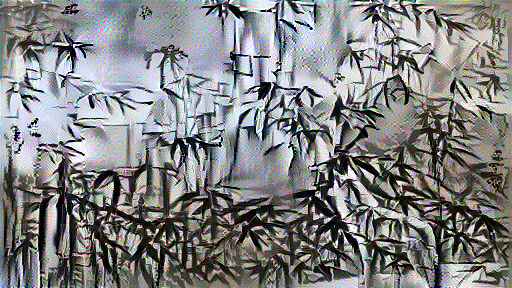

Train step: 1000


In [125]:
#@title Run the NST algorithm
#@markdown Change params for different results!!!

style_weight =  1.0    #@param {type:"number"}
content_weight = 0.025  #@param {type:"number"}
var_weight = 8.5e-5       #@param {type:"number"}

#@markdown Params default can be 2 of these options:

#@markdown style_weight =  1.0, content_weight = 0.025, var_weight = 8.5e-5

#@markdown style_weight =  1e-4, content_weight = 1e-32, var_weight = 1e-2

adam = tf.optimizers.Adam(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=30.0, decay_steps=100, decay_rate=0.90
    )
)

stylized_image_reg, display_images_reg = fit_style_transfer(style_image=style_image, content_image=content_image, 
                                                    style_weight=style_weight, content_weight=content_weight,
                                                    var_weight=var_weight, optimizer=adam, epochs=10, steps_per_epoch=100)

In [ ]:
# Display GIF
GIF_PATH = 'style_transfer_reg.gif'
gif_images_reg = [np.squeeze(image.numpy().astype(np.uint8), axis=0) for image in display_images_reg]
gif_path_reg = create_gif(GIF_PATH, gif_images_reg)
display_gif(gif_path_reg)

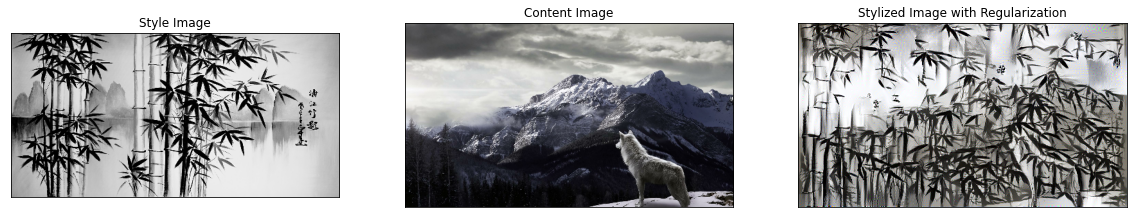

In [74]:
show_images_with_objects([style_image, content_image, stylized_image_reg], titles=['Style Image', 'Content Image', 'Stylized Image with Regularization'])

### Color Preservation with/wothout masked


In [ ]:
pip install scipy==1.1.0

In [2]:
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import

import argparse
import os
import numpy as np
from scipy.interpolate import interp1d
from scipy.misc import imread, imresize, imsave, fromimage, toimage

#### Util function to match histograms

In [5]:
def match_histograms(source, template):
    """
    Adjust the pixel values of a grayscale image such that its histogram
    matches that of a target image
    Arguments:
    -----------
        source: np.ndarray
            Image to transform; the histogram is computed over the flattened
            array
        template: np.ndarray
            Template image; can have different dimensions to source
    Returns:
    -----------
        matched: np.ndarray
            The transformed output image
    """

    oldshape = source.shape
    source = source.ravel()
    template = template.ravel()

    # get the set of unique pixel values and their corresponding indices and
    # counts
    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True,
                                            return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)

    # take the cumsum of the counts and normalize by the number of pixels to
    # get the empirical cumulative distribution functions for the source and
    # template images (maps pixel value --> quantile)
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]

    # interpolate linearly to find the pixel values in the template image
    # that correspond most closely to the quantiles in the source image
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)

    return interp_t_values[bin_idx].reshape(oldshape)

#### Util function to preserve image color

In [6]:
def original_color_transform(content, generated, mask=None, hist_match=0, mode='YCbCr'):
    generated = fromimage(toimage(generated, mode='RGB'), mode=mode)  # Convert to YCbCr color space

    if mask is None:
        if hist_match == 1:
            for channel in range(3):
                generated[:, :, channel] = match_histograms(generated[:, :, channel], content[:, :, channel])
        else:
            generated[:, :, 1:] = content[:, :, 1:]
    else:
        width, height, channels = generated.shape

        for i in range(width):
            for j in range(height):
                if mask[i, j] == 1:
                    if hist_match == 1:
                        for channel in range(3):
                            generated[i, j, channel] = match_histograms(generated[i, j, channel], content[i, j, channel])
                    else:
                        generated[i, j, 1:] = content[i, j, 1:]

    generated = fromimage(toimage(generated, mode=mode), mode='RGB')  # Convert to RGB color space
    return generated

#### Util function to load masks

In [7]:
def load_mask(mask_path, shape):
    mask = imread(mask_path, mode="L") # Grayscale mask load
    width, height, _ = shape
    mask = imresize(mask, (width, height), interp='bicubic').astype('float32')

    # Perform binarization of mask
    mask[mask <= 127] = 0
    mask[mask > 128] = 255

    mask /= 255
    mask = mask.astype(np.int32)

    return mask

#### Main part

In [134]:
content_path = Path('/content/content_image.jpg')
generated = Path('/content/download (5).png')
mask = None # with mask #Path(mask_path)
image_path = Path('/content/color.jpg')

In [ ]:
generated_image = imread(generated, mode="RGB")
img_width, img_height, _ = generated_image.shape

content_image = imread(content_path, mode="YCbCr")
content_image = imresize(content_image, (img_width, img_height), interp='bicubic')

In [137]:
mask_transfer = mask is not None
if mask_transfer:
    mask_img = load_mask(mask, generated_image.shape)
else:
    mask_img = None

In [ ]:
img = original_color_transform(content_image, generated_image, mask_img, hist_match=0, mode="YCbCr")
imsave(image_path, img)

### Masked Style Transfer

In [ ]:
pip install scipy==1.1.0

In [ ]:
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import

import argparse
import os
import numpy as np
from scipy.misc import imread, imresize, imsave

#### Util function to load masks

In [67]:
def load_mask(mask_path, shape):
    mask = imread(mask_path, mode="L") # Grayscale mask load
    width, height, _ = shape
    mask = imresize(mask, (width, height), interp='bicubic').astype('float32')

    # Perform binarization of mask
    mask[mask <= 127] = 0
    mask[mask > 128] = 255

    max = np.amax(mask)
    mask /= max

    return mask

#### Util function to apply mask to generated image


In [68]:
def mask_content(content, generated, mask):
    width, height, channels = generated.shape

    for i in range(width):
        for j in range(height):
            if mask[i, j] == 0.:
                generated[i, j, :] = content[i, j, :]

    return generated

#### Main part

In [114]:
content_path = Path('/content/drive/MyDrive/NST/data/content-images/winter-wolf.jpg')
generated = Path('/content/color1.jpg')
mask_path = Path('/content/drive/MyDrive/NST/data/mask/winter-wolf-mask.jpg')
image_path = Path('/content/color.jpg')

In [ ]:
generated_image = imread(generated, mode="RGB")
img_width, img_height, channels = generated_image.shape

content_image = imread(content_path, mode='RGB')
content_image = imresize(content_image, (img_width, img_height), interp='bicubic')

In [ ]:
mask = load_mask(mask_path, generated_image.shape)

img = mask_content(content_image, generated_image, mask)
imsave(image_path, img)

## Fast NST

In [60]:
import tensorflow_hub as hub

### Download the model

In [61]:
# this will take a few minutes to load
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

### Run the model

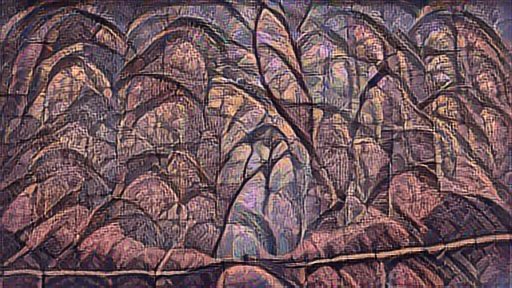

In [62]:
# stylize the image using the model you just downloaded
stylized_image = hub_module(tf.image.convert_image_dtype(content_image, tf.float32), 
                            tf.image.convert_image_dtype(style_image, tf.float32))[0]

# convert the tensor to image
tensor_to_image(stylized_image)

## Image super resolution algorithm

In [127]:
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

### Defining Helper Functions

In [126]:
def preprocess_image(image_path):
  """ Loads image from path and preprocesses to make it model ready
      Args:
        image_path: Path to the image file
  """
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  # If PNG, remove the alpha channel. The model only supports
  # images with 3 color channels.
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)

def save_image(image, filename):
  """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save.
  """
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)

%matplotlib inline
def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

### Performing Super Resolution of images loaded from path

In [128]:
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

In [139]:
hr_image = preprocess_image('/content/color.jpg')

Saved as Original Image.jpg


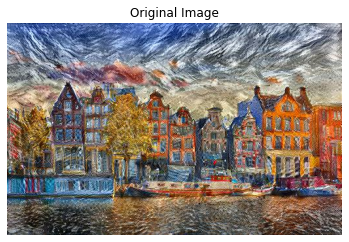

In [140]:
# Plotting Original Resolution image
plot_image(tf.squeeze(hr_image), title="Original Image")
save_image(tf.squeeze(hr_image), filename="Original Image")

In [129]:
model = hub.load(SAVED_MODEL_PATH)

Downloaded https://tfhub.dev/captain-pool/esrgan-tf2/1, Total size: 20.60MB



In [141]:
start = time.time()
fake_image = model(hr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 0.155010


Saved as Super Resolution.jpg


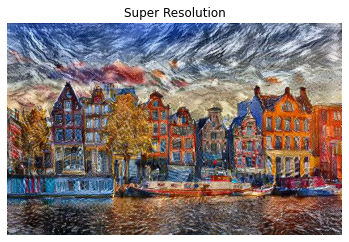

In [142]:
# Plotting Super Resolution Image
plot_image(tf.squeeze(fake_image), title="Super Resolution")
save_image(tf.squeeze(fake_image), filename="Super Resolution")